In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import fashion_mnist, plot_graphs
import numpy as np

In [17]:
train_loader, valid_loader, test_loader = fashion_mnist(valid=10000)

In [23]:
class Net(nn.Module):
    def __init__(self, overfit=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        
        self.overfit = overfit
        if overfit:
            self.fc2_2 = nn.Linear(128, 128)
        
        self.fc3 = nn.Linear(128, 10)
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        if self.overfit:
            x = torch.tanh(self.fc2_2(x))
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [33]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    train_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
        
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            
            train_loss[k] += m._loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
            
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)
        
        for k in models:
            test_loss[k] /= test_size
        
        correct_pct = {k: 100. * correct[k] / train_size for k in correct}
        if log is not None:
            for k in models:
                log[k].append((train_loss[k], correct_pct[k]))

In [40]:
models = {'default': Net(False), 'overfit': Net(True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [41]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loЕсли за неделю всех не зарегистрируют, мы придем к мэрии в субботу! Мы будем собираться столько, сколько потребуется! Каждый день!

ss[k], correct_pct[k]))
    print(report)

In [42]:
for epoch in range(1, 51):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses default: 2.314014 overfit: 2.313894
Train Epoch: 1 [10000/50000 (20%)]	Losses default: 0.896169 overfit: 0.940285
Train Epoch: 1 [20000/50000 (40%)]	Losses default: 0.680938 overfit: 0.690121
Train Epoch: 1 [30000/50000 (60%)]	Losses default: 0.523161 overfit: 0.518883
Train Epoch: 1 [40000/50000 (80%)]	Losses default: 0.489581 overfit: 0.485736
Train Epoch: 1 [50000/50000 (100%)]	Losses default: 0.559890 overfit: 0.564736
Test set:
default: Loss: 0.4800	Accuracy: 8322.0/10000 (83%)
overfit: Loss: 0.4651	Accuracy: 8377.0/10000 (84%)

Train Epoch: 2 [0/50000 (0%)]	Losses default: 0.496720 overfit: 0.469849
Train Epoch: 2 [10000/50000 (20%)]	Losses default: 0.488504 overfit: 0.504987
Train Epoch: 2 [20000/50000 (40%)]	Losses default: 0.323278 overfit: 0.309392
Train Epoch: 2 [30000/50000 (60%)]	Losses default: 0.254460 overfit: 0.230850
Train Epoch: 2 [40000/50000 (80%)]	Losses default: 0.367619 overfit: 0.407973
Train Epoch: 2 [50000/50000 (100%)]	Lo

Train Epoch: 15 [20000/50000 (40%)]	Losses default: 0.229052 overfit: 0.236335
Train Epoch: 15 [30000/50000 (60%)]	Losses default: 0.198219 overfit: 0.192607
Train Epoch: 15 [40000/50000 (80%)]	Losses default: 0.154414 overfit: 0.171727
Train Epoch: 15 [50000/50000 (100%)]	Losses default: 0.320955 overfit: 0.332291
Test set:
default: Loss: 0.3062	Accuracy: 8879.0/10000 (89%)
overfit: Loss: 0.3134	Accuracy: 8854.0/10000 (89%)

Train Epoch: 16 [0/50000 (0%)]	Losses default: 0.141408 overfit: 0.127039
Train Epoch: 16 [10000/50000 (20%)]	Losses default: 0.240731 overfit: 0.138403
Train Epoch: 16 [20000/50000 (40%)]	Losses default: 0.187312 overfit: 0.164324
Train Epoch: 16 [30000/50000 (60%)]	Losses default: 0.292633 overfit: 0.244046
Train Epoch: 16 [40000/50000 (80%)]	Losses default: 0.272216 overfit: 0.253670
Train Epoch: 16 [50000/50000 (100%)]	Losses default: 0.131462 overfit: 0.111673
Test set:
default: Loss: 0.3040	Accuracy: 8881.0/10000 (89%)
overfit: Loss: 0.3116	Accuracy: 8880.0/

Train Epoch: 29 [30000/50000 (60%)]	Losses default: 0.099966 overfit: 0.092866
Train Epoch: 29 [40000/50000 (80%)]	Losses default: 0.068431 overfit: 0.095627
Train Epoch: 29 [50000/50000 (100%)]	Losses default: 0.251491 overfit: 0.231882
Test set:
default: Loss: 0.3022	Accuracy: 8944.0/10000 (89%)
overfit: Loss: 0.3320	Accuracy: 8876.0/10000 (89%)

Train Epoch: 30 [0/50000 (0%)]	Losses default: 0.258758 overfit: 0.169164
Train Epoch: 30 [10000/50000 (20%)]	Losses default: 0.193781 overfit: 0.263963
Train Epoch: 30 [20000/50000 (40%)]	Losses default: 0.210983 overfit: 0.162381
Train Epoch: 30 [30000/50000 (60%)]	Losses default: 0.206806 overfit: 0.270116
Train Epoch: 30 [40000/50000 (80%)]	Losses default: 0.153508 overfit: 0.137487
Train Epoch: 30 [50000/50000 (100%)]	Losses default: 0.114074 overfit: 0.092575
Test set:
default: Loss: 0.3059	Accuracy: 8945.0/10000 (89%)
overfit: Loss: 0.3437	Accuracy: 8843.0/10000 (88%)

Train Epoch: 31 [0/50000 (0%)]	Losses default: 0.185280 overfit: 0

Train Epoch: 43 [40000/50000 (80%)]	Losses default: 0.078419 overfit: 0.067282
Train Epoch: 43 [50000/50000 (100%)]	Losses default: 0.062624 overfit: 0.064885
Test set:
default: Loss: 0.3478	Accuracy: 8913.0/10000 (89%)
overfit: Loss: 0.4065	Accuracy: 8868.0/10000 (89%)

Train Epoch: 44 [0/50000 (0%)]	Losses default: 0.169624 overfit: 0.144634
Train Epoch: 44 [10000/50000 (20%)]	Losses default: 0.042890 overfit: 0.042444
Train Epoch: 44 [20000/50000 (40%)]	Losses default: 0.038446 overfit: 0.040954
Train Epoch: 44 [30000/50000 (60%)]	Losses default: 0.121980 overfit: 0.167243
Train Epoch: 44 [40000/50000 (80%)]	Losses default: 0.131579 overfit: 0.133025
Train Epoch: 44 [50000/50000 (100%)]	Losses default: 0.110076 overfit: 0.053795
Test set:
default: Loss: 0.3416	Accuracy: 8945.0/10000 (89%)
overfit: Loss: 0.4008	Accuracy: 8873.0/10000 (89%)

Train Epoch: 45 [0/50000 (0%)]	Losses default: 0.183123 overfit: 0.188647
Train Epoch: 45 [10000/50000 (20%)]	Losses default: 0.049431 overfit: 0

In [51]:
for k in train_log:
    test_log['train_' + k] = train_log[k]

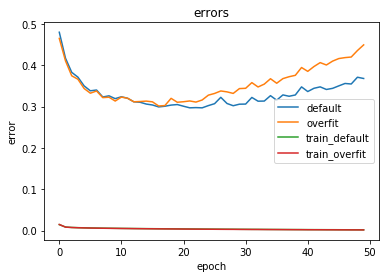

In [52]:
plot_graphs(test_log, 'loss')

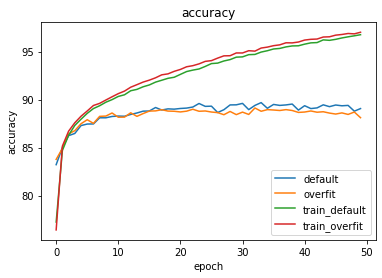

In [53]:
plot_graphs(test_log, 'accuracy')

In [54]:
test_log

{'default': [(0.48003528079986574, 83.22),
  (0.4171291745185852, 85.0),
  (0.38301271562576295, 86.24),
  (0.37134693231582644, 86.47),
  (0.3501354610919952, 87.29),
  (0.338332332611084, 87.45),
  (0.34023011274337767, 87.46),
  (0.32336779870986937, 88.1),
  (0.32617989587783813, 88.1),
  (0.3193323259830475, 88.24),
  (0.32391678771972654, 88.28),
  (0.3202932188034058, 88.26),
  (0.311685390329361, 88.45),
  (0.3106493412017822, 88.6),
  (0.30624428458213804, 88.79),
  (0.30398349070549013, 88.81),
  (0.29934564740657804, 89.17),
  (0.3009721823215485, 88.91),
  (0.30375839252471926, 89.03),
  (0.3050367521762848, 89.0),
  (0.30099252219200134, 89.07),
  (0.2971305552482605, 89.11),
  (0.2976653366088867, 89.22),
  (0.29708940315246585, 89.59),
  (0.302498443031311, 89.29),
  (0.3071599485397339, 89.31),
  (0.3225374290943146, 88.65),
  (0.3076305069446564, 88.94),
  (0.30220714373588564, 89.44),
  (0.3059282365322113, 89.45),
  (0.3061951253414154, 89.6),
  (0.32226602158546447,